# Gondwana

I want to visualize Gondwana and the nature of the margins around Gondwana during the time of the Sauk transgression.

In [1]:
import numpy as np
import fiona
import geopandas as gpd

import sys
sys.path.insert(1, r'pygplates_0.36.0_py310_win64/pygplates/')
import pygplates

import shapefile
import cartopy.crs as ccrs

from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib
font = {'size': 8}
matplotlib.rc('font', **font)

In [195]:
ceed_poly_path = 'gplates/ceed/CEED6_LAND.shp'
comp_subduct_path = 'gplates/compressional_subduction.gpml'
gond_path = 'gis/Gondwana/gondwana.shp'
non_gond_path = 'gis/Gondwana/non-Gondwana_510-490.shp'
rot_path = 'gplates/ceed/Torsvik_Cocks_HybridRotationFile.rot'

comp_subduct_df = gpd.read_file('gplates/compressional_subduction/compressional_subduction.shp')
# comp_subduct_df = comp_subduct_df.to_crs(proj4)

In [196]:
proj_plot = ccrs.Robinson()

t = 500

In [197]:
ceed_reconstruction = 'gplates/scratch/tmp.shp'
pygplates.reconstruct(ceed_poly_path, rot_path, ceed_reconstruction, t, 0)
paleo_geo = gpd.read_file(ceed_reconstruction)
paleo_geo = paleo_geo.to_crs(proj_plot)

gond_reconstruction = 'gplates/scratch/tmp2.shp'
pygplates.reconstruct(gond_path, rot_path, gond_reconstruction, t, 0)
gondwana = gpd.read_file(gond_reconstruction)

non_gond_reconstruction = 'gplates/scratch/tmp3.shp'
pygplates.reconstruct(non_gond_path, rot_path, non_gond_reconstruction, t, 0)
non_gondwana = gpd.read_file(non_gond_reconstruction)

Let's just visualize the modeled dynamic topography from Young et al. (2022) and overlay the Torsvik Gondwana reconstruction.

In [198]:
rootgrp = Dataset("gis/dynamic_topography/C1DT_MFgrid500_corrected.nc", "r", format="NETCDF4")

DT500 = rootgrp.variables['z'][:]
lat = rootgrp.variables['lat'][:]
lon = rootgrp.variables['lon'][:]

Text(0.5, 1.0, '500 Ma')

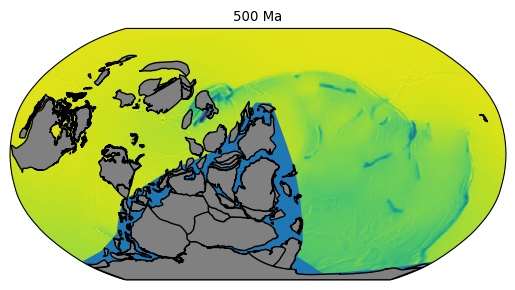

In [199]:
ax = plt.axes(projection=proj_plot)

ax.pcolormesh(lon, lat, DT500, transform=ccrs.PlateCarree())

gondwana.to_crs(proj_plot).plot(ax=ax)
paleo_geo.plot(ax=ax, edgecolor='k', linewidth=1, facecolor='gray')

# ax.set_axis_off()
ax.set_title(f'{t} Ma')

## Schematic Gondwana Dynamic Topography Figure 

In [200]:
# gondwana shapely poly
gondwana_sh = gondwana.geometry.values[0]

# get points from gondwana perimeter
gondwana_boundary = np.array([(lat, lon) for lon, lat in np.array(gondwana.boundary[0].coords)])

Found a great [stackoverflow answer](https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere) for generating points on a sphere; used the second solution.

In [201]:
from pygeodesy import sphericalTrigonometry as st
from shapely.geometry import Point

In [230]:
# make points on sphere
num_pts = 2000
indices = np.arange(0, num_pts, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/num_pts)
theta = np.pi * (1 + 5**0.5) * indices

# convert colatitude to latitude and save as lat lons
sphere_lat = 90 - np.rad2deg(phi)
sphere_lon = np.mod(np.rad2deg(theta), 360)-180

# set up for pygeodesy
sphere_LLs = [st.LatLon(lat, lon) for lat, lon in zip(sphere_lat, sphere_lon)]
gondwana_LLs = [st.LatLon(lat, lon) for lat, lon in gondwana_boundary]

# find nearest point on gondwana perimeter in terms of geodetic distance
closest = [st.nearestOn3(sphere_LL, gondwana_LLs, closed=True, limit=None) for sphere_LL in sphere_LLs]

# get actual distances
dists = np.array([x[1] for x in closest])

# determine if inside or outside polygon
in_gondwana = np.zeros(num_pts).astype(bool)
for ii in range(num_pts):
    cur_point = Point(sphere_lon[ii], sphere_lat[ii])
    in_gondwana[ii] = gondwana_sh.contains(cur_point)

# 1 if outside, -1 inside
in_gondwana = in_gondwana.astype(int)
in_gondwana[in_gondwana == 0] = -1
in_gondwana = -1 * in_gondwana

# scale dists by inside/outside
dists = dists * in_gondwana

# function to map colors based on distance and location in or outside of gondwana
def sigmoid(x, scale=1e6, center=0):
    # return 1/(1+np.exp(-(x-center)/scale))
    x = (x-center)/scale
    
    # asymmetric, longer scale for positive x 
#     y = np.zeros(len(x))
#     idx = x > 0
#     y[idx] = (x[idx]/2)/np.sqrt(1+(x[idx]/2)**2)
    
#     idx = x < 0
#     y[idx] = x[idx]/np.sqrt(1+x[idx]**2)
    
    return x/np.sqrt(1+x**2)

# schematic dt as output from sigmoid activation of distances
dt_schematic = np.zeros(num_pts)
idx = dists < 0
dt_schematic[idx] = sigmoid(dists[idx], scale=2e6)
idx = dists >= 0
dt_schematic[idx] = sigmoid(dists[idx], scale=6.5e6)

Now we need to adjust `dt_schematic` to reflect the zero-ish DT on non-Gondwanan continents.

In [231]:
# do the same as above but set to zero inside and have quickly decaying from zero to one outside
# loop over polygons, keep minimal distances
dists = np.zeros((num_pts, len(non_gondwana)))
for ii, polygon in enumerate(non_gondwana.geometry.values):
    # convert shapely polygon to coordinate pairs
    cur_boundary =  np.array([(lat, lon) for lon, lat in np.array(polygon.boundary.coords)])
    # convert to pygeodesy latlon
    cur_boundary_LLs = [st.LatLon(lat, lon) for lat, lon in cur_boundary]
    # find nearest point on gondwana perimeter in terms of geodetic distance
    cur_closest = [st.nearestOn3(sphere_LL, cur_boundary_LLs, closed=True, limit=None) for sphere_LL in sphere_LLs]

    # get actual distances
    dists[:, ii] = np.array([x[1] for x in cur_closest])

    # determine if inside or outside polygon
    in_cur_poly = np.zeros(num_pts).astype(bool)
    for jj in range(num_pts):
        cur_point = Point(sphere_lon[jj], sphere_lat[jj])
        in_cur_poly[jj] = polygon.contains(cur_point)
    
    # 1 if outside, 0 inside
    in_cur_poly = 1 - in_cur_poly.astype(int)

    # scale dists by inside/outside
    dists[:, ii] = dists[:, ii] * in_cur_poly

In [232]:
# use minimum of distances
dists = np.min(dists, axis=1)

# multiplicative factor for non-Gondwana continents
dt_fact = sigmoid(dists, scale=5e5)

dt_schematic = dt_fact * dt_schematic

Nice function for cropping existing colormaps, from [stackoverflow](https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib).

In [233]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

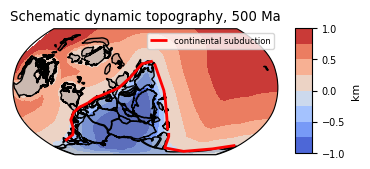

In [234]:
cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.0, maxval=1)

proj_plot = ccrs.Robinson()

t = 500

fig = plt.figure(figsize=(3.42, 2.5))
ax = plt.axes(projection=proj_plot)

# ax.pcolormesh(lon, lat, DT500, transform=ccrs.PlateCarree())

im = ax.tricontourf(sphere_lon, sphere_lat, dt_schematic, 
               cmap=cmap, transform=ccrs.PlateCarree())

ceed_reconstruction = 'gplates/scratch/tmp.shp'
pygplates.reconstruct(ceed_poly_path, rot_path, ceed_reconstruction, t, 0)
paleo_geo = gpd.read_file(ceed_reconstruction)
paleo_geo = paleo_geo.to_crs(proj_plot)

# gond_reconstruction = 'gplates/scratch/tmp2.shp'
# pygplates.reconstruct(gond_path, rot_path, gond_reconstruction, t, 0)
# gondwana = gpd.read_file(gond_reconstruction)

reconstruction_comp_sub = 'gplates/scratch/tmp2.shp'
pygplates.reconstruct(comp_subduct_path, rot_path, reconstruction_comp_sub, t, 0)
paleo_comp_subduct = gpd.read_file(reconstruction_comp_sub)
paleo_comp_subduct = paleo_comp_subduct.to_crs(proj_plot)
    
# gondwana.to_crs(proj_plot).plot(ax=ax)
paleo_geo.boundary.plot(ax=ax, edgecolor='k', linewidth=1, alpha=1)
paleo_geo.plot(ax=ax, linewidth=0, alpha=0.3, facecolor='grey')
paleo_comp_subduct.plot(ax=ax, color='r', linewidth=2, label='continental subduction')

ax.legend(fontsize=6)
ax.set_title(f'Schematic dynamic topography, {t} Ma')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
cax = plt.axes([0.95, 0.25, 0.05, 0.5])
cbar = plt.colorbar(im, cax=cax, ticks=[-1, -0.5, 0, 0.5, 1], label='km')
cbar.ax.tick_params(labelsize=7)

plt.savefig('figures/gondwana_dt.pdf', format='pdf', bbox_inches='tight')
plt.show()